In [10]:
%pip install 'numpy<2.0'
%pip install 'scipy<1.13.0'
%pip install fastsparsegams

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import pandas as pd
import fastsparsegams
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

np.random.seed(42)

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [12]:
def convert_continuous_df_to_binary_df(df):
    """Convert continuous features to binary features in the dataframe.

    Generates 100 percentile thresholds for each feature.

    Parameters:
        df (pandas.DataFrame): The input dataframe containing continuous features.

    Returns:
        pandas.DataFrame: The binary dataframe with converted features.
    """
    colnames = df.columns
    n = len(df)
    print("Make sure your first column corresponds to the y label")
    print("Converting continuous features to binary features in the dataframe......")

    percentile_ticks = range(1, 101)

    binarized_dict = {}

    for i in range(0, len(colnames)):
        uni = df[colnames[i]].unique()
        if len(uni) == 2:
            binarized_dict[colnames[i]] = np.asarray(df[colnames[i]], dtype=int)
            continue

        uni.sort()
        if len(uni) >= 100:
            uni = np.percentile(uni, percentile_ticks)
        for j in range(len(uni) - 1):
            tmp_feature = np.ones(n, dtype=int)
            tmp_name = colnames[i] + "<=" + str(uni[j])

            zero_indices = df[colnames[i]] > uni[j]
            tmp_feature[zero_indices] = 0

            binarized_dict[tmp_name] = tmp_feature

    binarized_df = pd.DataFrame(binarized_dict)
    print("Finish converting continuous features to binary features......")
    return binarized_df

In [13]:
def plot_shape_functions_fastsparse(gam, binary_cols, continuous_df, lambda_0=0):
    """Plot the shape functions of a GAM model using the fastsparse package.

    Parameters:
        gam: The trained GAM model.
        binary_cols: The binary column names used in the GAM model.
        continuous_df: The continuous dataframe used in the GAM model.
        lambda_0 (float, optional): The regularization parameter. Defaults to 0.

    Returns:
        None
    """
    gam_coeffs = gam.coeff(lambda_0=lambda_0)
    intercept = gam_coeffs[0]
    coefficients = gam_coeffs[1:]
    used_binary_features = binary_cols[coefficients.indices]  # of form "feature_name<=threshold"
    feature_names = np.unique([feature.split("<=")[0] for feature in used_binary_features])
    print(intercept)
    for feature_name in feature_names:
        feature_indices = []
        for i, feature in enumerate(used_binary_features):
            if feature_name in feature:
                feature_indices.append(i)

        feature_min = continuous_df[feature_name].min()
        feature_max = continuous_df[feature_name].max()
        steps = [float(feature.split("<=")[1]) for feature in used_binary_features[feature_indices]]
        steps = [feature_min] + steps + [feature_max]

        coefficients_lte = gam_coeffs.data[feature_indices]
        coefficients_lte_steps = convert_coefficients_to_shape_function(coefficients_lte, direction="<")
        coefficients = coefficients_lte_steps


        plot_shape_function(steps, coefficients, feature_name)
def convert_coefficients_to_shape_function(coefficients, direction="<"):
    """Convert the gam feature coefficients to a step/shape function.

    This is needed to make the coefficient representation conform to the
    alignment expectations of plt.step, which are somewhat unintuitive.
    You can figure out how to do this yourself with a whiteboard and some patience,
    but I did that for you :)

    Parameters:
        coefficients (list[float]): The coefficients of the shape function.
        direction (str, optional): The direction of the step function.
            Can be "<" or ">". Defaults to "<".

    Returns:
        list[float]: The step function coefficients.
    """
    coefficients_steps = np.zeros(len(coefficients)+2)
    if direction == "<":
        coeff_reverse_cumsum = np.cumsum(coefficients[::-1])[::-1]
        coefficients_steps[1:-1] = coeff_reverse_cumsum
        coefficients_steps[0] = coeff_reverse_cumsum[0]
    else:
        coeff_cumsum = np.cumsum(coefficients)
        coefficients_steps[2:] = coeff_cumsum
    return coefficients_steps
def plot_shape_function(steps: list[float], coefficients: list[float], feature_name: str, ax=None):
    """Plot the shape function of the GAM for a single feature.

    The shape function is a piecewise constant function that is the sum of the coefficients
    where the feature value is less than or equal to the step (or greater than).

    Parameters:
        steps (list[float]): The steps in the shape function. Assume these are sorted in ascending order.
        coefficients (list[float]): The coefficients of the shape function.
        feature_name (str): The name of the feature.
        ax (matplotlib.axes.Axes, optional): The axes on which to plot the shape function.
            If not provided, a new figure and axes will be created.

    Returns:
        None
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.step(steps, coefficients, where="pre")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Shape function")
    ax.set_title(f"Shape function for {feature_name}")
    plt.show()

In [14]:
data_path = "/Users/JudyWork/Desktop/Research/474-GAMS/data/FICO/heloc_dataset_v1.csv"
df = pd.read_csv(data_path)

# Extract features and target
X = df.drop('RiskPerformance', axis=1).astype(np.float64)
y = (df['RiskPerformance'] == 'Good').astype(int) # Convert to binary: 1 for 'Good', 0 for 'Bad'

# split into 15% test, 10% validation, 75% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/(1-.15), random_state=43)

In [15]:
binary_df = convert_continuous_df_to_binary_df(pd.concat([y, X], axis=1))
X_binary = binary_df[binary_df.columns[1:]]
y_binary = binary_df[binary_df.columns[0]]

X_binary_train = X_binary.iloc[X_train.index]
y_binary_train = y_binary.iloc[X_train.index]

X_binary_val = X_binary.iloc[X_val.index]
y_binary_val = y_binary.iloc[X_val.index]

X_binary_test = X_binary.iloc[X_test.index]
y_binary_test = y_binary.iloc[X_test.index]


Make sure your first column corresponds to the y label
Converting continuous features to binary features in the dataframe......
Finish converting continuous features to binary features......


In [16]:
X_train_fsg = X_binary_train.values.astype(float)
y_train_fsg = y_binary_train.values

X_test_fsg = X_binary_test.values.astype(float)
y_test_fsg = y_binary_test.values

In [17]:
from sklearn.metrics import accuracy_score


lambdas = [0.8, 1, 2, 3, 4, 5, 6, 7]
gammas = [0.00001, 0.001]
penalty_type = "L0L2"
ell = "Logistic"
results = []

for g in gammas:
    for l in lambdas:
        
        start_time = time.time()
    
        # Fit GAM model
        model = fastsparsegams.fit(
            X_train_fsg, 
            y_train_fsg, 
            algorithm="CDPSI",
            penalty=penalty_type,
            loss=ell,
            lambda_grid=np.array([[l]]),
            num_gamma=None,
            num_lambda=None,
            gamma_max=g,
            gamma_min=g
        )
        
        # Measure fitting time
        end_time = time.time()
        train_time = end_time-start_time
        print(f"train finished in {train_time}s")
        
        for i, lambda_val in enumerate(model.characteristics()["l0"]):
            support_size = model.characteristics()["support_size"][i]
            beta = model.coeff(lambda_0=lambda_val, gamma=g)
            
            intercept, b = beta[0], beta[1:]
            y_pred_train = model.predict(X_train_fsg, lambda_0=lambda_val, gamma=g)
            y_pred_test = model.predict(X_test_fsg, lambda_0=lambda_val, gamma=g)

            auc_train = roc_auc_score(y_train_fsg, y_pred_train)
            auc_test = roc_auc_score(y_test_fsg, y_pred_test)
            acc_train = accuracy_score(y_train_fsg, (y_pred_train >= 0.5).astype(int))
            acc_test = accuracy_score(y_test_fsg, (y_pred_test >= 0.5).astype(int))

            result = ["fastsparse", ell, penalty_type, lambda_val, g, support_size, 
                        auc_train, auc_test, acc_train, acc_test, train_time]
            results.append(result)

log_file = "fastsparseresults.csv"
df = pd.DataFrame(results, columns=[
        "algorithm", "loss", "penalty_type",
        "lambda", "gamma", "support_size", "auc_train", "auc_test", "acc_train", "acc_test", "train_time"
    ])
df.to_csv(log_file, mode="a", header=True, index=False, float_format="%.6f")
print("Results logged to", log_file)

train finished in 6.395701885223389s
train finished in 3.4249489307403564s
train finished in 1.9775381088256836s
train finished in 1.8600389957427979s
train finished in 1.7972450256347656s
train finished in 0.9946980476379395s
train finished in 0.8805413246154785s
train finished in 0.7957398891448975s
train finished in 4.734885931015015s
train finished in 3.0752148628234863s
train finished in 1.1572790145874023s
train finished in 1.4008779525756836s
train finished in 1.2441539764404297s
train finished in 1.134093999862671s
train finished in 0.8586969375610352s
train finished in 0.6941027641296387s
Results logged to fastsparseresults.csv



Fitting GAM with 200 smoothing parameters...
Best accuracy: 0.734225621414914, AUC: 0.7327967541598313, lambda_0: 0.8339763253114889, support size: 48
  (0, 0)	0.12769804393253506


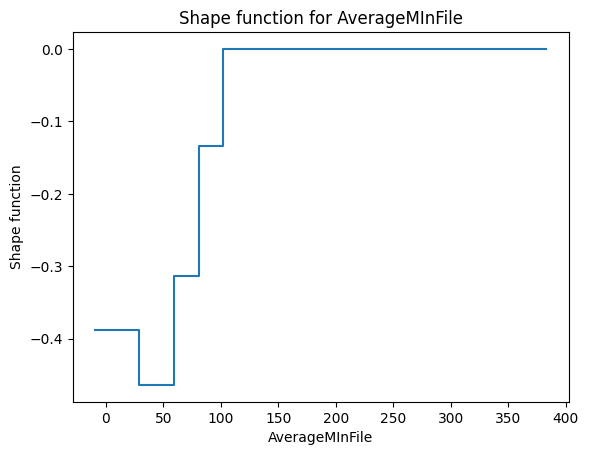

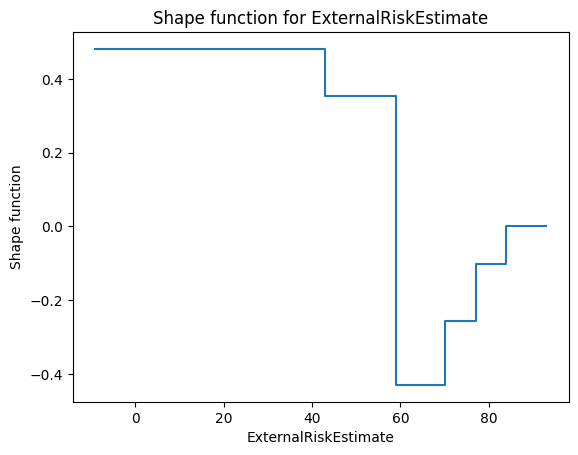

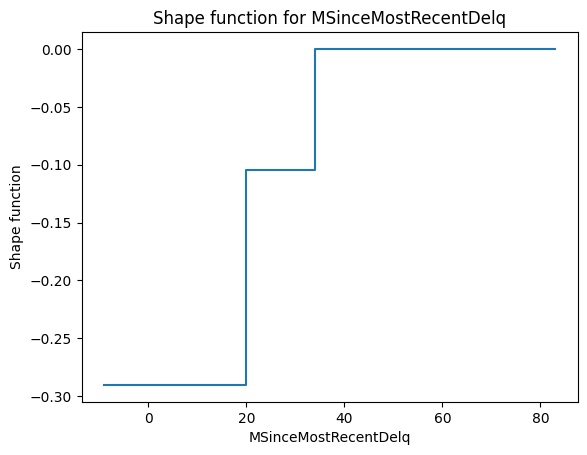

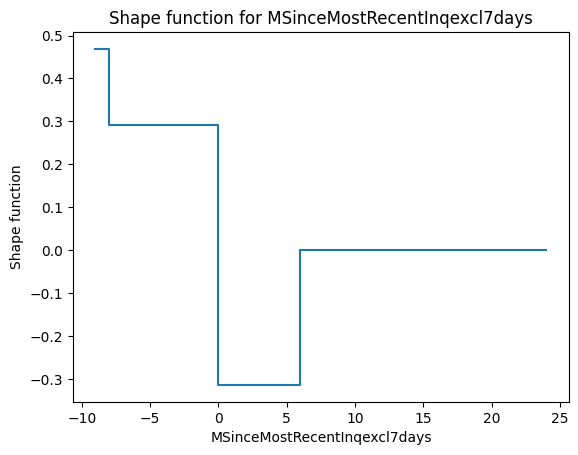

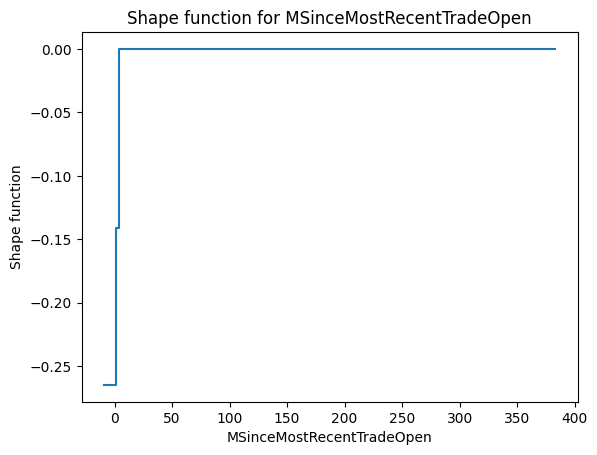

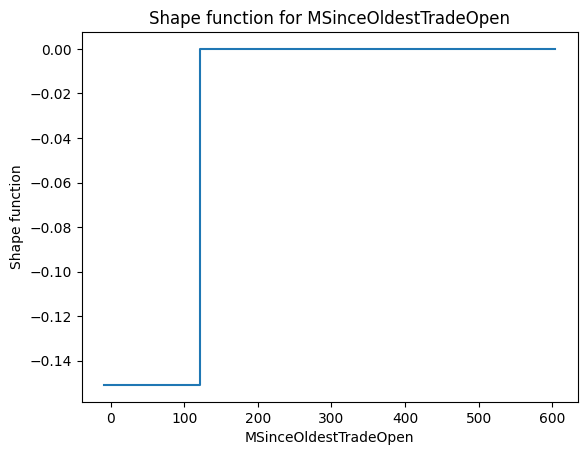

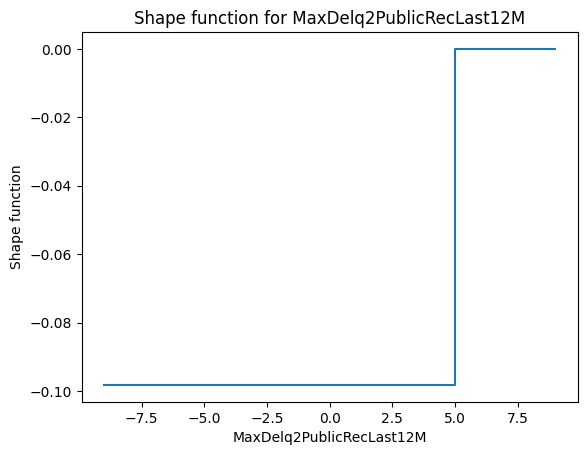

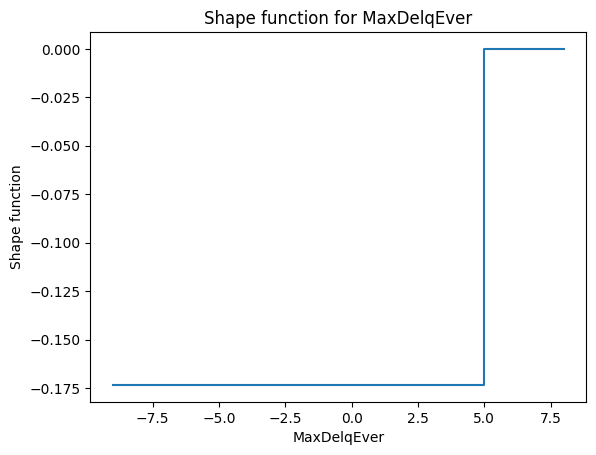

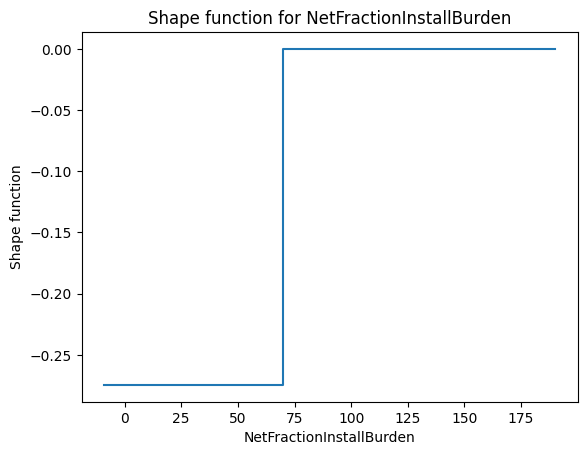

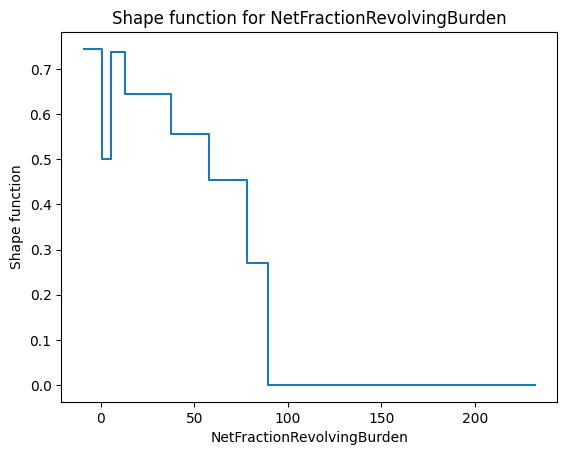

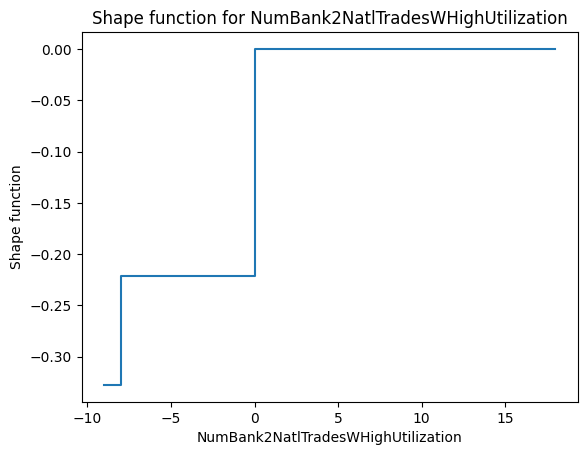

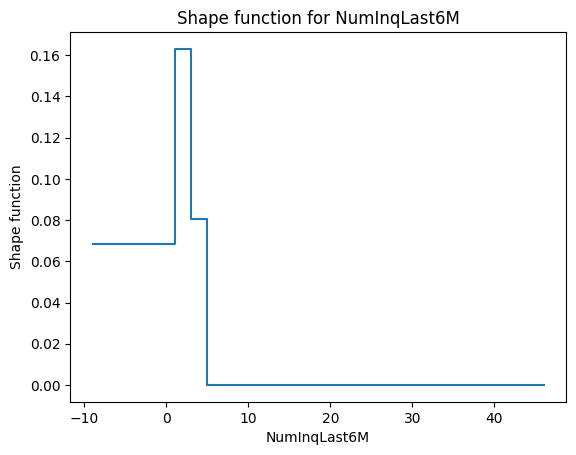

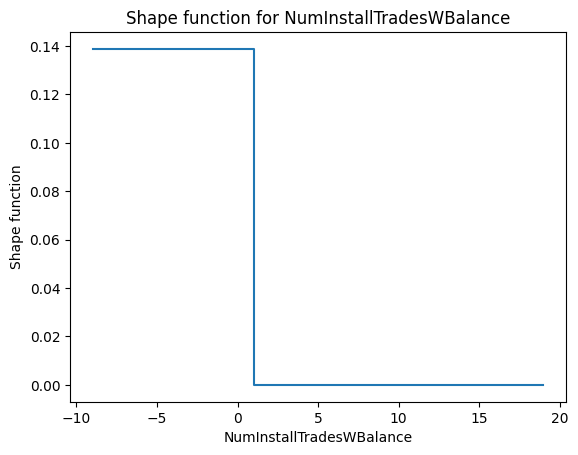

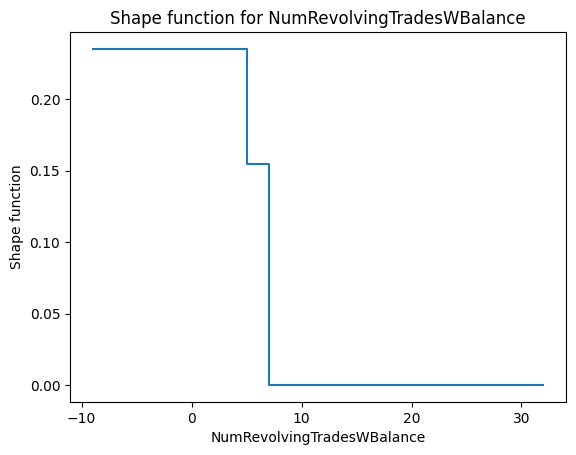

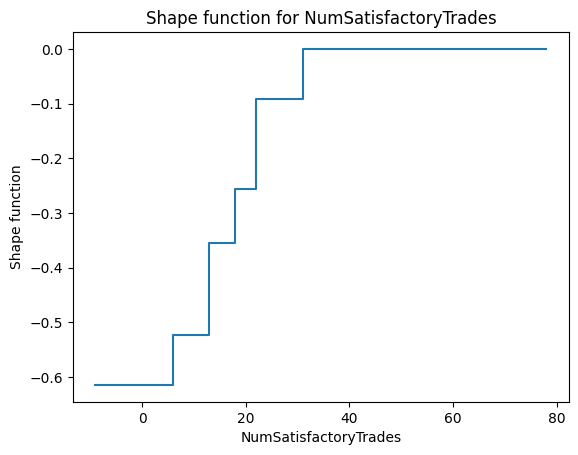

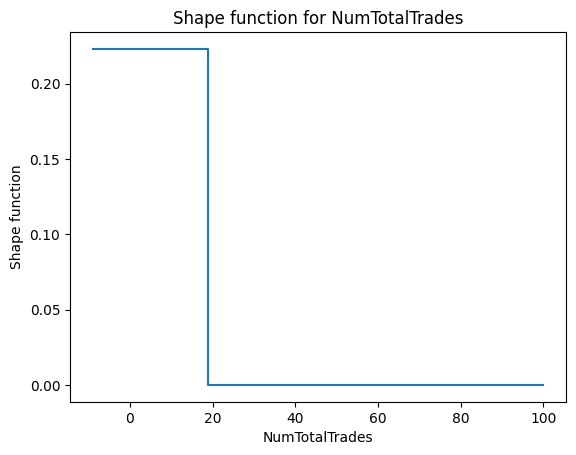

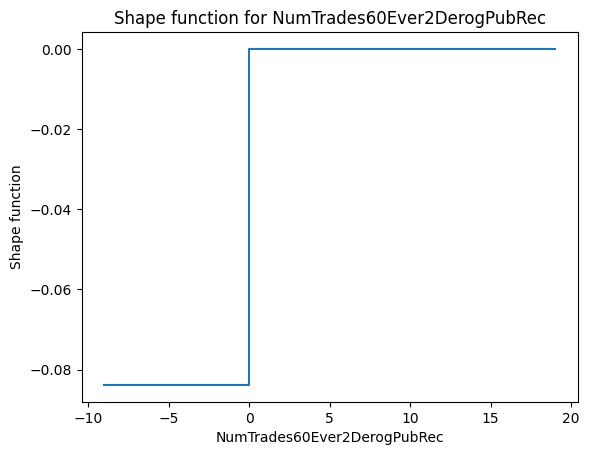

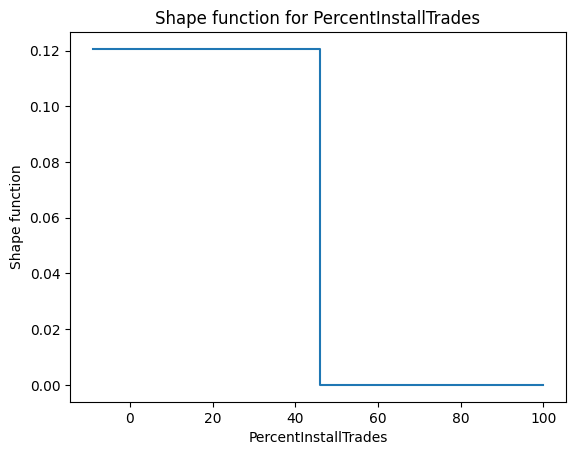

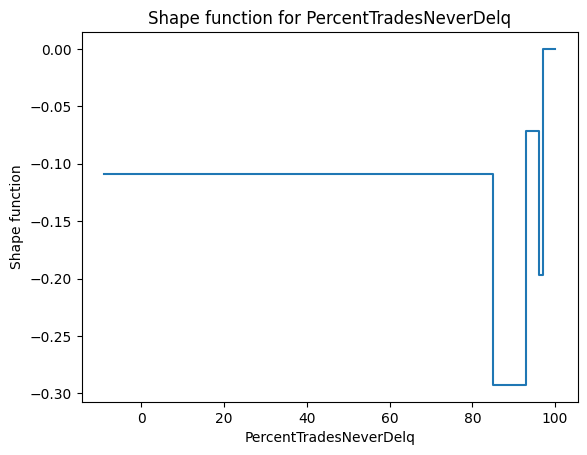

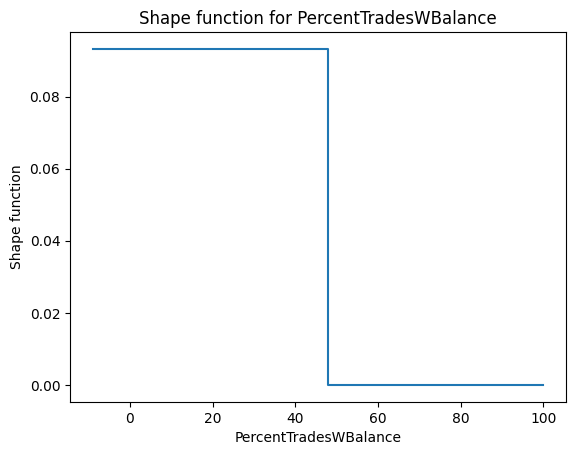


Fitting Times (seconds):
200 smoothing parameters: 59.6159 sec


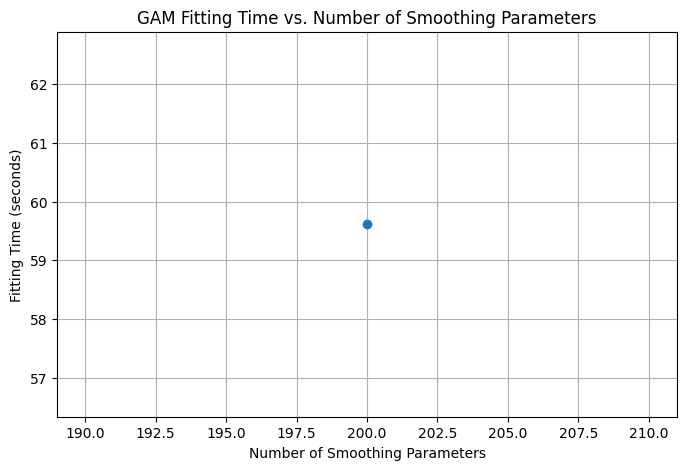

In [18]:
from sklearn.metrics import accuracy_score

max_support_sizes = [200]

fit_times = {}

for sp in max_support_sizes:
   
    print(f"\nFitting GAM with {sp} smoothing parameters...")
    start_time = time.time()
    
    # Fit GAM model
    gam = fastsparsegams.fit(
        X_train_fsg, 
        y_train_fsg, 
        algorithm="CDPSI",
        penalty='L0',
        loss='Exponential',
        max_support_size=sp,
    )
    
    # Measure fitting time
    end_time = time.time()
    fit_times[sp] = end_time - start_time


    best_val_accuracy = 0
    best_lambda = 0  # regularization
    best_support_size = 0
    best_auc = 0

    # Find the best lambda_0 and support_size based on validation accuracy
    for index, row in gam.characteristics().iterrows():
        support_size = row['support_size']
        lambda_0 = row['l0']
        y_pred = gam.predict(x=X_binary_val, lambda_0=lambda_0, gamma=0)
        
        # Convert probabilities to binary labels (0 or 1) using a threshold of 0.5
        y_pred_binary = (y_pred >= 0.5).astype(int)
        val_accuracy = accuracy_score(y_binary_val, y_pred_binary)
        val_auc = roc_auc_score(y_binary_val, y_pred_binary)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_lambda = lambda_0
            best_support_size = support_size
            best_auc = val_auc

    print(f"Best accuracy: {best_val_accuracy}, AUC: {best_auc}, lambda_0: {best_lambda}, support size: {best_support_size}")

    plot_shape_functions_fastsparse(gam=gam, binary_cols=X_binary.columns, continuous_df=X_train, lambda_0=best_lambda)
    
# Print fitting times
print("\nFitting Times (seconds):")
for sp, t in fit_times.items():
    print(f"{sp} smoothing parameters: {fit_times[sp]:.4f} sec")

# Plot fitting times separately
plt.figure(figsize=(8, 5))
plt.plot(max_support_sizes, [fit_times[sp] for sp in max_support_sizes], marker='o')
plt.xlabel('Number of Smoothing Parameters')
plt.ylabel('Fitting Time (seconds)')
plt.title('GAM Fitting Time vs. Number of Smoothing Parameters')
plt.grid(True)
plt.savefig('fastSparse_gam_timing_comparison.png', dpi=300)
plt.show()